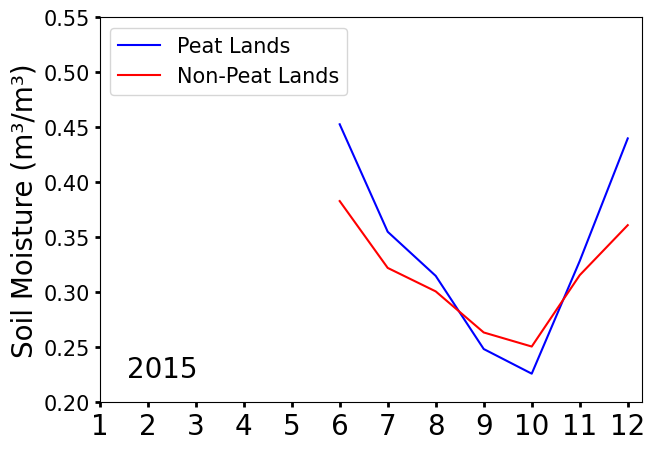

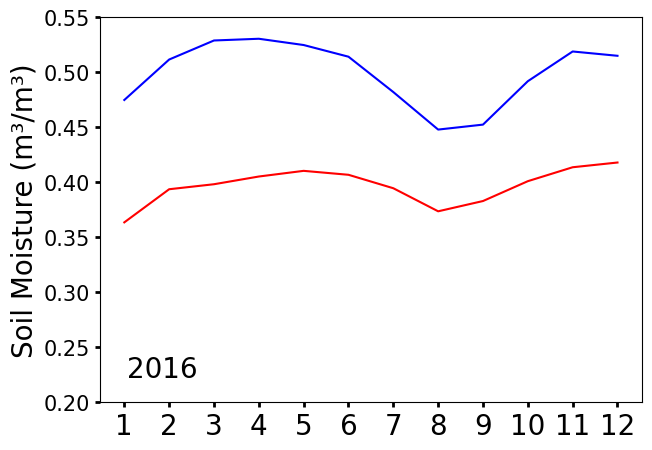

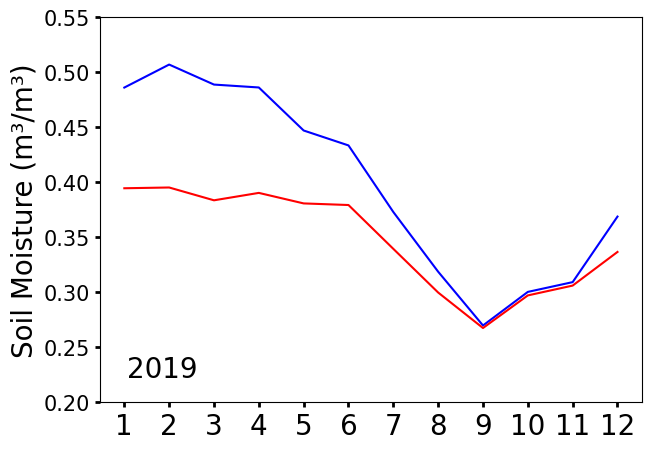

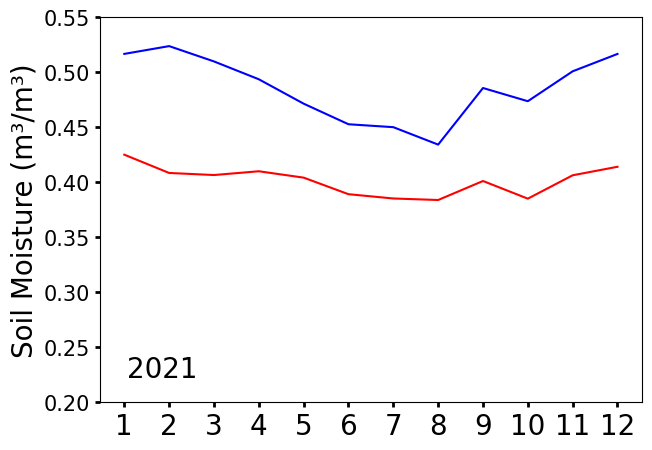

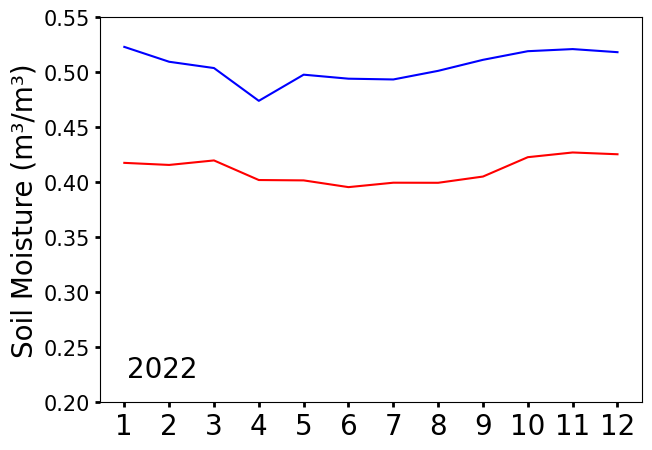

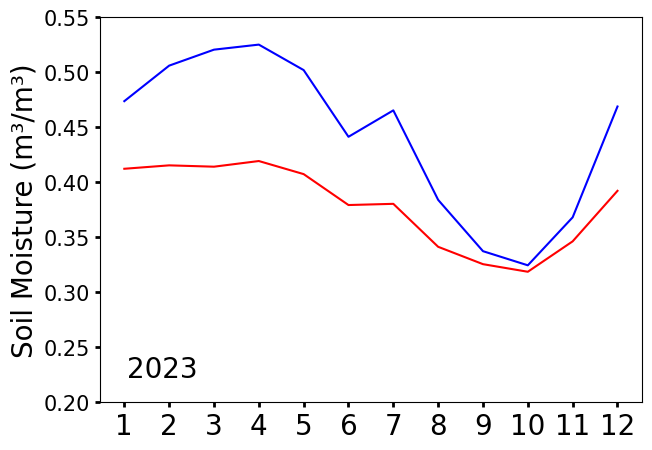

In [7]:
import fiona
from shapely.geometry import shape, mapping
import numpy as np
import matplotlib.pyplot as plt
import rasterio.features
import xarray as xr

# 加载土壤湿度NetCDF文件
smap_data = xr.open_dataset('SMAP_monthly_mean_soil_moisture_indonesia.nc')['soil_moisture_monthly_mean_indonesia']

# 打开shapefile文件并转换几何形状
with fiona.open('Indonesia_Peat_Lands.shp') as src:
    peat_land_geoms = [shape(feature['geometry']) for feature in src]

# 定义目标网格
transform = rasterio.transform.from_bounds(
    smap_data.lon.min().item(), smap_data.lat.min().item(),
    smap_data.lon.max().item(), smap_data.lat.max().item(),
    smap_data.sizes['lon'], smap_data.sizes['lat']
)

# 手动裁剪数据数组
def manual_clip(da, shapes, transform):
    mask = np.zeros((da.sizes['lat'], da.sizes['lon']), dtype=bool)
    for geom in shapes:
        geom_mask = rasterio.features.geometry_mask([mapping(geom)], 
                                                    transform=transform, 
                                                    invert=True, 
                                                    out_shape=(da.sizes['lat'], da.sizes['lon']))
        mask = mask | geom_mask
    return da.where(mask)

# 裁剪泥炭地土壤湿度数据
soil_moisture_peat_manual = manual_clip(smap_data, peat_land_geoms, transform)

# 裁剪非泥炭地土壤湿度数据
soil_moisture_non_peat_manual = smap_data.where(~soil_moisture_peat_manual.notnull())

# 只保存指定年份
years = [2015, 2016, 2019, 2021, 2022, 2023]

# 检查数据中的年份
available_years = np.unique(smap_data['time'].dt.year.data)
valid_years = [year for year in years if year in available_years]

# 绘制每个年份的土壤湿度数据
for i, year in enumerate(valid_years):
    soil_moisture_peat_year = soil_moisture_peat_manual.sel(time=smap_data['time'].dt.year == year)
    soil_moisture_non_peat_year = soil_moisture_non_peat_manual.sel(time=smap_data['time'].dt.year == year)
    
    fig, ax = plt.subplots(figsize=(7, 5))
    
    ax.plot(soil_moisture_peat_year.time.dt.month, soil_moisture_peat_year.mean(['lon', 'lat']), color='b', label='Peat Lands')
    ax.plot(soil_moisture_non_peat_year.time.dt.month, soil_moisture_non_peat_year.mean(['lon', 'lat']), color='r', label='Non-Peat Lands')
    
    ax.set_ylabel('Soil Moisture (m³/m³)', fontsize=20)
    
    # 调整x轴和y轴刻度
    ax.tick_params(axis='both', which='major', labelsize=15,width=2)  # 调整刻度标签字体大小和刻度线宽度
    
    ax.set_xticks(range(1, 13))
    ax.set_xticklabels(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'], fontsize=20) #调整x轴刻度标签的字体大小
    
    # 固定y轴刻度在0.2到0.6之间
    ax.set_ylim([0.2, 0.55])
    
    # 只在第一张图上显示图例
    if i == 0:
        ax.legend(loc='upper left', fontsize=15)  # 设置图例位置在左上角
    
    # 在图的左下角添加年份标签
    ax.text(
        0.05,  # x 坐标（相对位置，0 为最左，1 为最右）
        0.05,  # y 坐标（相对位置，0 为最底，1 为最顶）
        f'{year}',  # 文本内容
        transform=ax.transAxes,  # 坐标系统（相对坐标系统）
        fontsize=20,  # 字体大小调整为 20
        ha='left',  # 水平对齐方式
        va='bottom',  # 垂直对齐方式
        color='black',  # 文字颜色
        bbox=dict(facecolor='none', alpha=0.7, edgecolor='none')  # 背景框样式
    )
    
    # 保存图像
    plt.savefig(f'F5 {year}.png', dpi=600, bbox_inches='tight')
    plt.show()
    plt.close(fig)
